## XAFS Data Processing (matplotlib)
This example shows how to use Larch from Python/Jupyter for basic XAFS data processing:

  1. read data from an Athena Project File
  2. do XAFS background subtraction with autobk()
  3. do XAFS Fourier transform with xfft()

In this version, plotting will be done with "standard inline matplotlib", which will embed plots into the Notebook. 
This is probably the most common way to plot data in Jupyter and the Scipy ecosystem. 

If you are interested, you can also check out the XAFS_Processing_plotly and XAFS_Processing_wx notebooks.

For more details on Larch, see https://xraypy.github.io/xraylarch/xafs/

We'll start with reading and exploring the Athena Project File:

In [2]:
from larch.io import read_athena
project = read_athena('../xafsdata/fe_athena.prj')

for name, group in project.groups.items():
    print(name, group)

fe2o3_rt1_xmu <Group 0x18661b200>
fe3c_rt_xdi <Group 0x1865bd0a0>
feo_rt1_xmu <Group 0x18661b3e0>


> **NOTE** For additional features of working with Athena project files -> [IO_Athena_project.ipynb](./IO_Athena_project.ipynb) 

Let's get that data group for Fe2O3 and look at what that Group object contains

In [3]:
fe2o3 = project.fe2o3_rt1_xmu
for attr in dir(fe2o3):
    print(attr, type(getattr(fe2o3, attr)))

athena_id <class 'str'>
athena_params <class 'larch.symboltable.Group'>
atsym <class 'str'>
callargs <class 'larch.symboltable.Group'>
d2mude <class 'numpy.ndarray'>
datatype <class 'str'>
dmude <class 'numpy.ndarray'>
e0 <class 'numpy.float64'>
edge <class 'str'>
edge_step <class 'float'>
edge_step_poly <class 'float'>
energy <class 'numpy.ndarray'>
energy_shift <class 'float'>
epsk <class 'float'>
epsr <class 'float'>
filename <class 'str'>
flat <class 'numpy.ndarray'>
i0 <class 'numpy.ndarray'>
journal <class 'larch.larchlib.Journal'>
label <class 'str'>
mu <class 'numpy.ndarray'>
norm <class 'numpy.ndarray'>
norm_poly <class 'numpy.ndarray'>
plot_xlabel <class 'str'>
plot_ylabel <class 'str'>
post_edge <class 'numpy.ndarray'>
pre_edge <class 'numpy.ndarray'>
pre_edge_details <class 'larch.symboltable.Group'>
sel <class 'int'>
signal <class 'numpy.ndarray'>
xdat <class 'numpy.ndarray'>
ydat <class 'numpy.ndarray'>
yerr <class 'float'>


There are several components to this Group of data.  We note that there are arrays for `energy` and `mu`.   These are what represent $\mu(E)$.

----------

To plot this data with Matplotlib, we need to tell Jupyter to use "inline matplotib", and import the pyplot module:

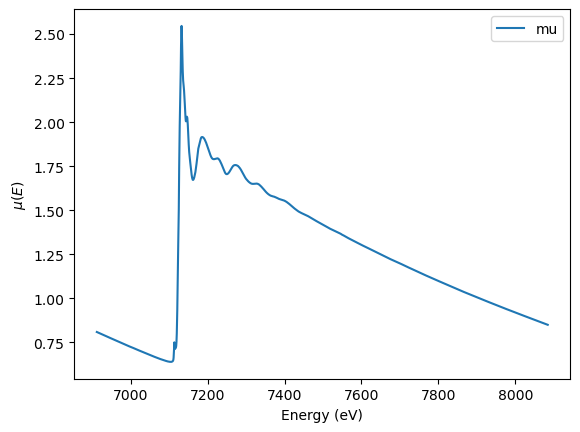

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(fe2o3.energy, fe2o3.mu, label='mu')
plt.xlabel('Energy (eV)')
plt.ylabel(r'$\mu(E)$')
plt.legend()

Let's now subtract the pre-edge and normalize all the Fe datasets


fe2o3_rt1_xmu 7125.6176 1.2930835174651394
fe3c_rt_xdi 7122.5 2.42352172994476
feo_rt1_xmu 7122.9272 1.354364206322157


Text(0, 0.5, '$\\mu(E)$')

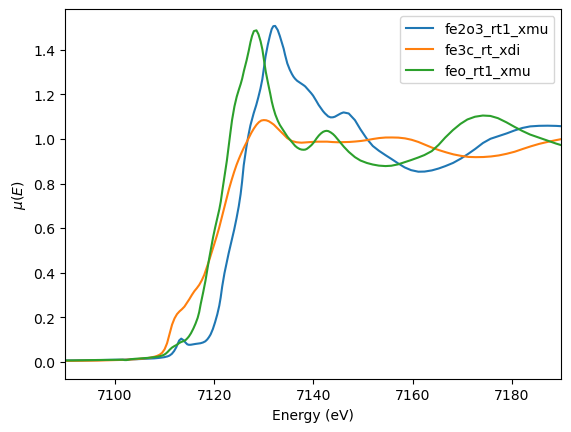

In [5]:
from larch.xafs import pre_edge

for name, group in project.groups.items():
    pre_edge(group)
    print(name, group.e0, group.edge_step)
    
for name, group in project.groups.items():
    plt.plot(group.energy, group.norm, label=name)
    
plt.legend()
plt.xlim(7090, 7190)
plt.xlabel('Energy (eV)')
plt.ylabel(r'$\mu(E)$')

Now let's focus on the Fe2O3 data and remove the XAFS background and extract the EXAFS $\chi(k)$.   We'll use
the `autobk()` function (https://xraypy.github.io/xraylarch/xafs/autobk.html)

Note that we pass in the *Group* as the first argument.  The `autobk()` function will add several attributes to this Group -- it will be the container for this dataset.

Text(0, 0.5, '$\\mu(E)$')

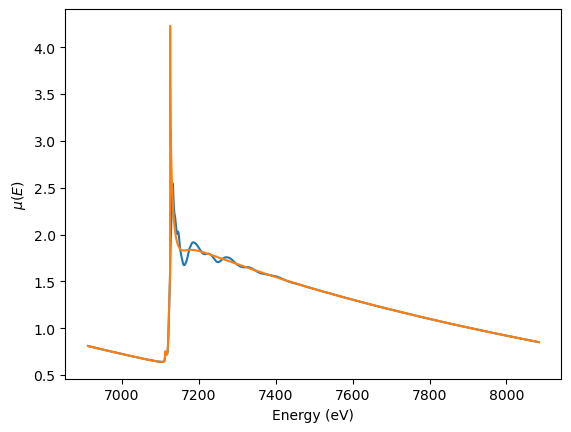

In [6]:
from larch.xafs import autobk
autobk(fe2o3, rbkg=0.9, kweight=2)

plt.plot(fe2o3.energy, fe2o3.mu, label='mu')
plt.plot(fe2o3.energy, fe2o3.bkg, label='bkg')
plt.xlabel('Energy (eV)')
plt.ylabel(r'$\mu(E)$')

We'll also want to plot $\chi(k)$. And, Larch includes some pre-defined plot labels using Latex formatting, so let's use those: 

['k', 'r', 'energy', 'ewithk', 'i0', 'mu', 'norm', 'flat', 'deconv', 'dmude', 'd2mude', 'chie', 'chie0', 'chie1', 'chiew', 'chikw', 'chi0', 'chi1', 'chi2', 'chi3', 'chir', 'chirmag', 'chirre', 'chirim', 'chirpha', 'e0color', 'chirlab', 'x', 'y', 'xdat', 'ydat', 'xplot', 'yplot', 'ynorm', 'xshift', 'dydx', 'd2ydx']


Text(0, 0.5, '$\\chi(k)$')

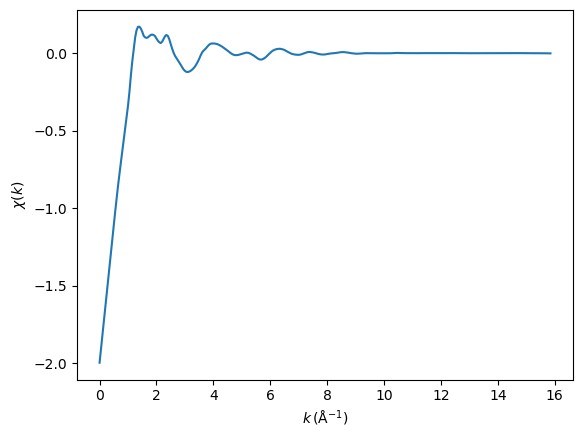

In [7]:
from larch.wxlib import plotlabels as plab
print(plab.keys())

plt.plot(fe2o3.k, fe2o3.chi)
plt.xlabel(plab.k)
plt.ylabel(plab.chi0)

but we usually want to plot $k$-weighted $\chi(k)$:

Text(0, 0.5, '$k^{2}\\chi(k) \\rm\\,(\\AA^{-2})$')

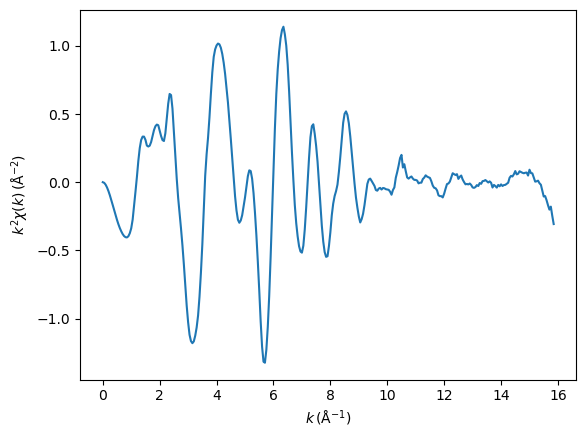

In [8]:
plt.plot(fe2o3.k, fe2o3.chi*fe2o3.k**2, label='$\chi$')
plt.xlabel(plab.k)
plt.ylabel(plab.chikw.format(2))

and now we will do the Fourier transform from $\chi(k)$ to $\chi(R)$, using the `xftf()` (XAFS Fourier Transform Forward) function.  We'll do the Fourier transform on $k^2$ weighted $\chi(k)$ with a Kaiser-Bessel Window. 

In [9]:
from larch.xafs import xftf
xftf(fe2o3, kweight=2, kmin=2, kmax=13.0, dk=5, kwindow='Kaiser-Bessel')

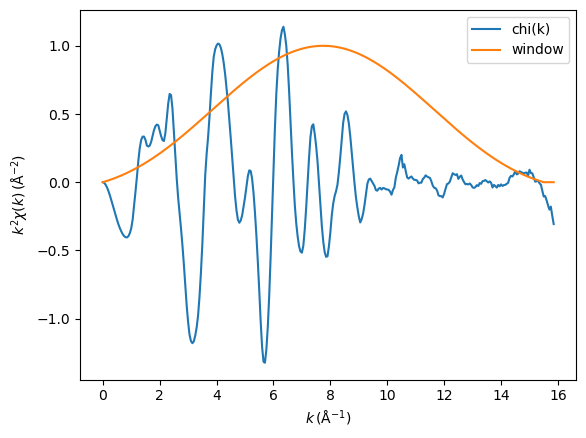

In [10]:
plt.plot(fe2o3.k, fe2o3.chi*fe2o3.k**2, label='chi(k)')
plt.plot(fe2o3.k, fe2o3.kwin, label='window')
plt.xlabel(plab.k)
plt.ylabel(plab.chikw.format(2))
plt.legend()

and we can show that data as $\chi(R)$

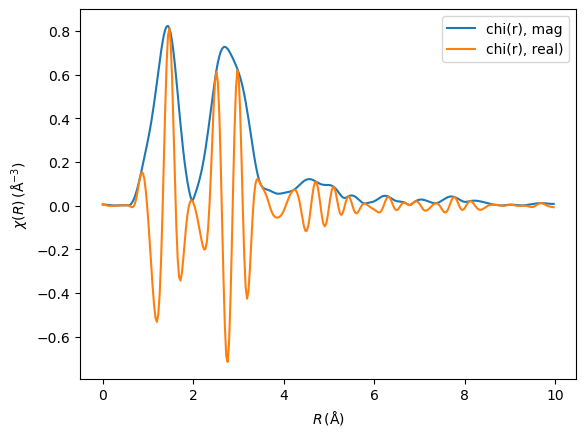

In [11]:
plt.plot(fe2o3.r, fe2o3.chir_mag, label='chi(r), mag')
plt.plot(fe2o3.r, fe2o3.chir_re, label='chi(r), real)')
plt.xlabel(plab.r)
plt.ylabel(plab.chir.format(3))
plt.legend()

So for, we've emphasized how to plot the data, so let's try another dataset with all the processing at once:

Text(0, 0.5, '$k^{2}\\chi(k) \\rm\\,(\\AA^{-2})$')

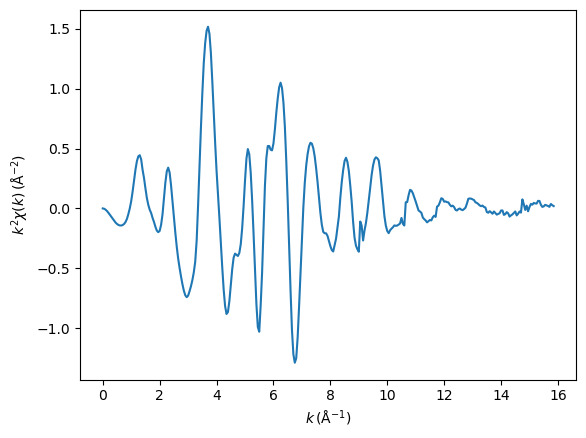

In [12]:
feo = project.feo_rt1_xmu

autobk(feo, rbkg=0.9, kweight=2)
xftf(feo, kweight=2, kmin=2, kmax=13.0, dk=5, kwindow='Kaiser-Bessel')

plt.plot(feo.k, feo.chi*feo.k**2)
plt.xlabel(plab.k)
plt.ylabel(plab.chikw.format(2))

Text(0, 0.5, '$\\chi(R) \\rm\\,(\\AA^{-3})$')

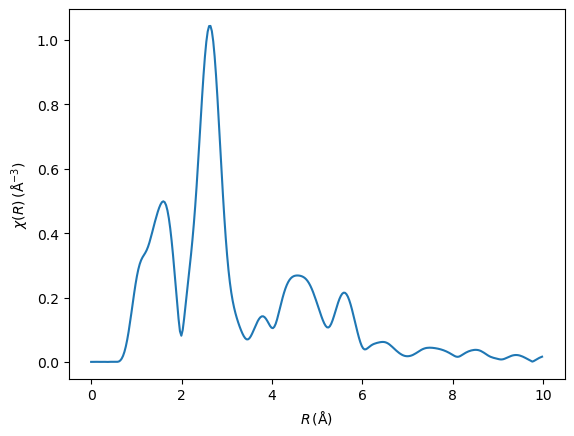

In [13]:
plt.plot(feo.r, feo.chir_mag)
plt.xlabel(plab.r)
plt.ylabel(plab.chir.format(3))